# Random Forest Classifier on Galaxy10 CLIP Embeddings

This notebook trains a Random Forest classifier on Galaxy10 CLIP embeddings.
A manual hyperparameter search is conducted using a validation set.
The final model is evaluated on a separate test set using multiple performance metrics.
Additional visualizations of decision boundaries based on important features are provided.

In [37]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import product

# Ensure reproducibility
np.random.seed(42)

## Data Loading

The Galaxy10 dataset is loaded. The data is divided into:
- Training set for model fitting.
- Validation set for hyperparameter tuning.
- Test set for final model evaluation.

Embeddings are high-dimensional. The data is imbalanced, which is considered during training and evaluation.

In [38]:
# Data Loading and Dimensionality Reduction
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Original data
X_train_original = data['train_features']
y_train = data['train_labels']
X_val_original = data['val_features']
y_val = data['val_labels']
X_test_original = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original embedding dimension: {X_train_original.shape[1]}")


# Apply PCA
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_original)
X_val = pca.transform(X_val_original)
X_test = pca.transform(X_test_original)

print(f"Reduced embedding dimension after PCA: {X_train.shape[1]}")

Original embedding dimension: 2048
Reduced embedding dimension after PCA: 25


## Hyperparameter Search

Manual search over:
- Number of estimators
- Maximum tree depth
- Minimum samples required to split a node

Model performance is evaluated using validation accuracy and balanced accuracy.
Balanced accuracy is used to address class imbalance.
Class weights are set to 'balanced' during training.

In [39]:
# Define parameter grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [50, 100],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}

param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split']
))

results = []

for n_estimators, max_depth, min_samples_split in param_combinations:
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth if max_depth is not None else -1,
        'min_samples_split': min_samples_split,
        'val_accuracy': val_accuracy,
        'val_balanced_accuracy': val_balanced_accuracy,
        'val_f1': val_f1
    })

results_df = pd.DataFrame(results)
results_df

,n_estimators,max_depth,min_samples_split,val_accuracy,val_balanced_accuracy,val_f1
0,500,50,2,0.868767,0.766104,0.867921
1,500,50,5,0.869685,0.768123,0.868835
2,500,50,10,0.868767,0.766772,0.868154
3,500,100,2,0.868767,0.766104,0.867921
4,500,100,5,0.869685,0.768123,0.868835
5,500,100,10,0.868767,0.766772,0.868154
6,1000,50,2,0.870603,0.767633,0.869812
7,1000,50,5,0.869991,0.768767,0.869294
8,1000,50,10,0.869073,0.768297,0.868372
9,1000,100,2,0.870603,0.767633,0.869812


## Hyperparameter Search Results

The validation balanced accuracy across hyperparameters is visualized.
Missing data is avoided, and the entire grid is shown clearly.

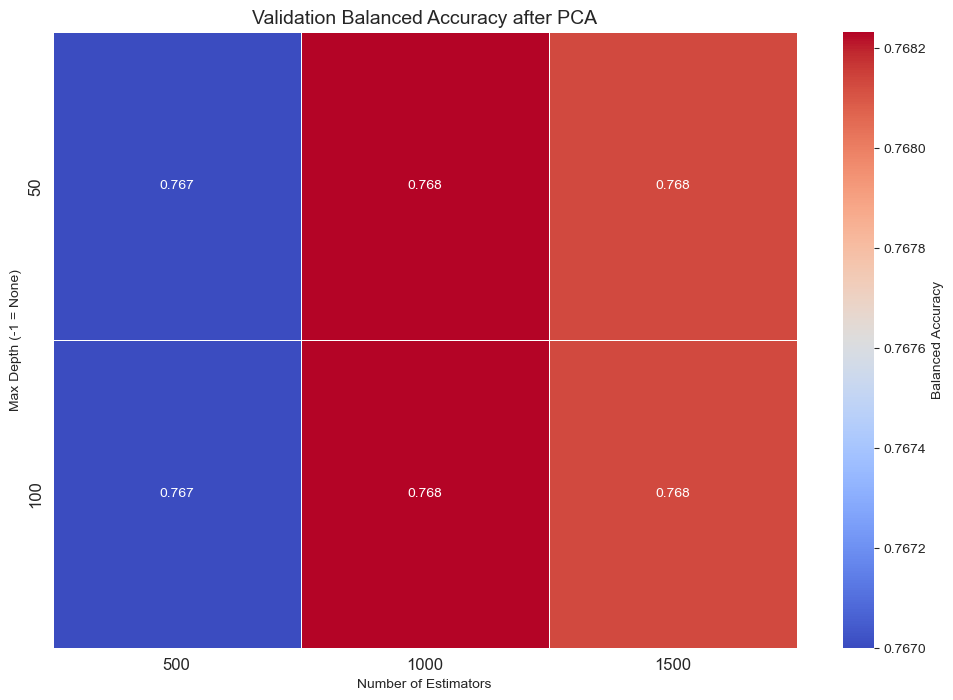

In [40]:
pivot_table = results_df.pivot_table(
    index='max_depth',
    columns='n_estimators',
    values='val_balanced_accuracy'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'Balanced Accuracy'})
plt.title('Validation Balanced Accuracy after PCA', fontsize=14)
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth (-1 = None)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Selection of Best Hyperparameters

The best hyperparameters are selected based on validation balanced accuracy.

In [41]:
# Select best hyperparameters
best_params = results_df.loc[results_df['val_balanced_accuracy'].idxmax()]
best_params

n_estimators             1000.000000
max_depth                  50.000000
min_samples_split           5.000000
val_accuracy                0.869991
val_balanced_accuracy       0.768767
val_f1                      0.869294
Name: 7, dtype: float64

## Retrain Final Model

The model is retrained on the combination of training and validation sets with the best hyperparameters.

In [42]:
# Select Best Hyperparameters and Retrain on Train + Validation Set
best_params = results_df.loc[results_df['val_balanced_accuracy'].idxmax()]

# Combine training and validation sets
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

best_model = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=None if best_params['max_depth'] == -1 else int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train_val, y_train_val)

# Predictions on test set
y_test_pred = best_model.predict(X_test)

## Test Set Evaluation

The final model is evaluated on the test set using:
- Accuracy
- Balanced Accuracy
- Precision
- Recall
- F1 Score

In [43]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8782
Test Balanced Accuracy: 0.7531
Test Precision: 0.8765
Test Recall: 0.8782
Test F1 Score: 0.8771


## Confusion Matrix

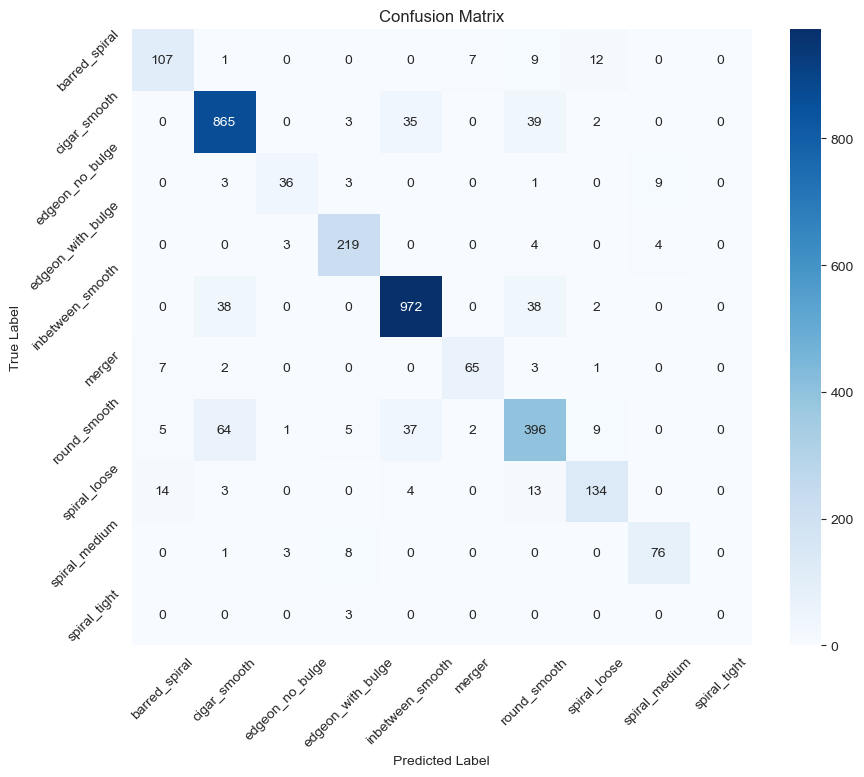

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Classification Report

In [45]:
# Detailed classification report
print(classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral       0.80      0.79      0.80       136
     cigar_smooth       0.89      0.92      0.90       944
  edgeon_no_bulge       0.84      0.69      0.76        52
edgeon_with_bulge       0.91      0.95      0.93       230
 inbetween_smooth       0.93      0.93      0.93      1050
           merger       0.88      0.83      0.86        78
     round_smooth       0.79      0.76      0.77       519
     spiral_loose       0.84      0.80      0.82       168
    spiral_medium       0.85      0.86      0.86        88
     spiral_tight       0.00      0.00      0.00         3

         accuracy                           0.88      3268
        macro avg       0.77      0.75      0.76      3268
     weighted avg       0.88      0.88      0.88      3268



## Hierarchical Clustering Based on Confusion Matrix

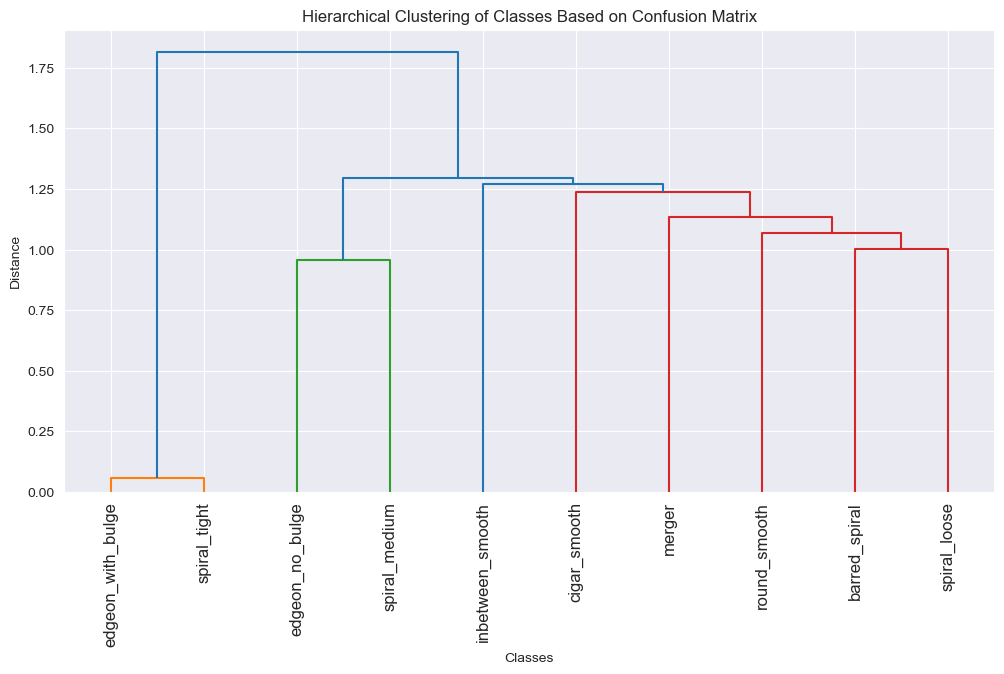

In [46]:
# Normalize confusion matrix by true class count
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

linked = linkage(cm_normalized, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=class_names, leaf_rotation=90)
plt.title('Hierarchical Clustering of Classes Based on Confusion Matrix')
plt.xlabel('Classes')
plt.ylabel('Distance')
plt.show()

## Decision Boundary Visualization

Two most important features are selected for visualization.
Decision boundaries are plotted in two dimensions for interpretability.

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

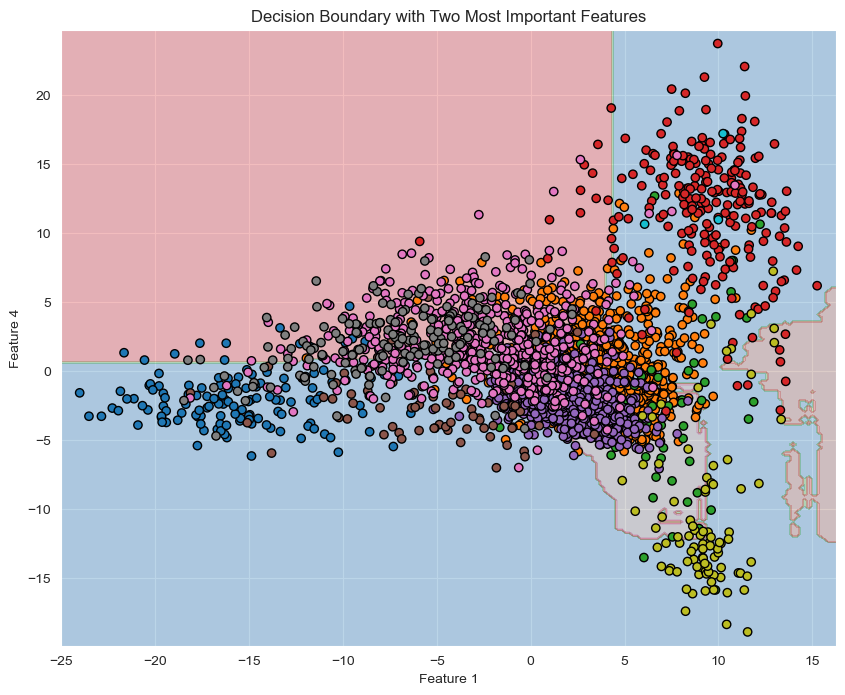

In [47]:
# Feature Importance
importances = best_model.feature_importances_
important_indices = np.argsort(importances)[::-1]

# Select top 2 important dimensions
dim1, dim2 = important_indices[0], important_indices[1]

# Scatter plot with decision boundaries
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

# Create a mesh grid
x_min, x_max = X_test[:, dim1].min() - 1, X_test[:, dim1].max() + 1
y_min, y_max = X_test[:, dim2].min() - 1, X_test[:, dim2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh grid
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], X_test.shape[1]-2))])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')

# Plot test points
scatter = plt.scatter(X_test[:, dim1], X_test[:, dim2], c=y_test, cmap='tab10', edgecolor='k')
plt.xlabel(f'Feature {dim1}')
plt.ylabel(f'Feature {dim2}')
plt.title('Decision Boundary with Two Most Important Features')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()